In [92]:
import pandas as pd

df = pd.read_csv('matchups_2024.csv')
df

,game_id,away_team_id,home_team_id,team_id,team_name,team_city,team_tricode,team_slug,person_id,first_name,...,matchup_three_pointers_made,matchup_three_pointers_attempted,matchup_three_pointers_percentage,help_blocks,help_field_goals_made,help_field_goals_attempted,help_field_goals_percentage,matchup_free_throws_made,matchup_free_throws_attempted,shooting_fouls
0,22400001,1610612737,1610612738,1610612738,Celtics,Boston,BOS,celtics,1627759,Jaylen,...,0,0,0.0,0,0,0,0,0,0,0
1,22400001,1610612737,1610612738,1610612738,Celtics,Boston,BOS,celtics,1627759,Jaylen,...,0,0,0.0,0,0,0,0,1,2,1
2,22400001,1610612737,1610612738,1610612738,Celtics,Boston,BOS,celtics,1627759,Jaylen,...,3,5,0.6,0,0,0,0,3,4,2
3,22400001,1610612737,1610612738,1610612738,Celtics,Boston,BOS,celtics,1627759,Jaylen,...,0,0,0.0,0,0,0,0,0,0,0
4,22400001,1610612737,1610612738,1610612738,Celtics,Boston,BOS,celtics,1627759,Jaylen,...,0,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231956,22401230,1610612745,1610612760,1610612745,Rockets,Houston,HOU,rockets,1628988,Aaron,...,0,0,0.0,0,0,0,0,0,0,0
231957,22401230,1610612745,1610612760,1610612745,Rockets,Houston,HOU,rockets,1628988,Aaron,...,0,0,0.0,0,0,0,0,0,0,0
231958,22401230,1610612745,1610612760,1610612745,Rockets,Houston,HOU,rockets,1628988,Aaron,...,0,0,0.0,0,0,0,0,0,0,0
231959,22401230,1610612745,1610612760,1610612745,Rockets,Houston,HOU,rockets,1628988,Aaron,...,0,0,0.0,0,0,0,0,0,0,0


## Preprocessing

In [93]:
player_position_map = df[['person_id', 'position', 'team_name', 'team_city', 'team_slug']].drop_duplicates()

player_position_map = player_position_map.rename(columns={
    'person_id': 'matchups_person_id',
    'position': 'matchups_position',
    'team_name': 'matchups_team_name',
    'team_city': 'matchups_team_city',
    'team_slug': 'matchups_team_slug'
})

df_updated = df.merge(player_position_map, on='matchups_person_id', how='left')
df_updated[['matchups_person_id', 'matchups_first_name','matchups_family_name','matchups_position', 'matchups_team_name', 'matchups_team_city', 'matchups_team_slug']].drop_duplicates()

,matchups_person_id,matchups_first_name,matchups_family_name,matchups_position,matchups_team_name,matchups_team_city,matchups_team_slug
0,203991,Clint,Capela,C,Hawks,Atlanta,hawks
1,203991,Clint,Capela,NaN,Hawks,Atlanta,hawks
2,1630700,Dyson,Daniels,G,Hawks,Atlanta,hawks
3,1630552,Jalen,Johnson,F,Hawks,Atlanta,hawks
4,1629726,Garrison,Mathews,NaN,Hawks,Atlanta,hawks
...,...,...,...,...,...,...,...
471282,1630296,Braxton,Key,NaN,Warriors,Golden State,warriors
498703,1630600,Isaiah,Mobley,NaN,76ers,Philadelphia,sixers
498979,1631199,Ron,Harper Jr.,NaN,Pistons,Detroit,pistons
498988,1642449,Tolu,Smith,NaN,Pistons,Detroit,pistons


In [94]:
df_updated['matchup_two_pointers_made'] = (
    df_updated['matchup_field_goals_made'] - df_updated['matchup_three_pointers_made']
)

df_updated['matchup_two_pointers_attempted'] = (
    df_updated['matchup_field_goals_attempted'] - df_updated['matchup_three_pointers_attempted']
)

In [95]:
# Filter defenders who played >= 1300 minutes (example threshold for full-season data)
qualified_minutes = df.groupby('matchups_person_id')['matchup_minutes_sort'].sum()
qualified_defenders = qualified_minutes[qualified_minutes >= 1300 * 60].index

# Keep only rows with qualified defenders
df = df[df['matchups_person_id'].isin(qualified_defenders)].copy()

In [96]:
# Ensure numeric types
numeric_cols = [
    'matchup_field_goals_made', 'matchup_field_goals_attempted', 'matchup_three_pointers_made',
    'matchup_three_pointers_attempted', 'matchup_free_throws_made', 'matchup_free_throws_attempted',
    'matchup_turnovers', 'matchup_blocks', 'help_blocks', 'help_field_goals_made',
    'help_field_goals_attempted', 'shooting_fouls', 'matchup_minutes_sort', 'player_points'
]
for col in numeric_cols:
    df_updated[col] = pd.to_numeric(df_updated[col], errors='coerce').fillna(0)

# Ensure derived two-pointer fields are numeric
df_updated['matchup_two_pointers_made'] = pd.to_numeric(df_updated['matchup_two_pointers_made'], errors='coerce').fillna(0)
df_updated['matchup_two_pointers_attempted'] = pd.to_numeric(df_updated['matchup_two_pointers_attempted'], errors='coerce').fillna(0)

# Convert matchup_minutes to float
def convert_minutes_to_float(minutes_str):
    try:
        minutes, seconds = map(int, str(minutes_str).split(':'))
        return minutes + seconds / 60
    except:
        return pd.to_numeric(minutes_str, errors='coerce').fillna(0)

df_updated['matchup_minutes'] = df_updated['matchup_minutes'].apply(convert_minutes_to_float)

# Build shot-level dataset
shot_rows = []
for _, row in df_updated.iterrows():
    fga = int(row["matchup_field_goals_attempted"])
    fgm = int(row["matchup_field_goals_made"])
    for i in range(fga):
        shot_rows.append({
            'attacker_id': row['person_id'],
            'defender_id': row['matchups_person_id'],
            'attacker_position': row['position'],
            'defender_position': row['matchups_position'],
            'is_made': 1 if i < fgm else 0,
            'is_three_point': 1 if row['matchup_three_pointers_attempted'] > 0 else 0,
            'game_id': row['game_id'],
            'matchup_minutes': row['matchup_minutes'],
            'matchup_blocks': row['matchup_blocks'],
            'help_blocks': row['help_blocks'],
            'shooting_fouls': row['shooting_fouls'],
            'player_points': row['player_points']
        })

shot_df = pd.DataFrame(shot_rows)

In [103]:
df_updated.to_csv('ATLvsBOS_v2.csv', index=False)
shot_df.to_csv('ATLvsBOS_v2_shots.csv',index=False)
shot_df.head(100)

,attacker_id,defender_id,attacker_position,defender_position,is_made,is_three_point,game_id,matchup_minutes,matchup_blocks,help_blocks,shooting_fouls,player_points
0,1627759,1630700,F,G,1,0,22400001,2.950000,0,0,1,7
1,1627759,1630700,F,G,1,0,22400001,2.950000,0,0,1,7
2,1627759,1630700,F,G,1,0,22400001,2.950000,0,0,1,7
3,1627759,1630700,F,G,0,0,22400001,2.950000,0,0,1,7
4,1627759,1630552,F,F,1,1,22400001,7.850000,1,0,2,20
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1628401,1642258,G,G,0,1,22400001,3.016667,0,0,1,7
96,1628401,1630811,G,G,1,1,22400001,6.783333,0,0,0,11
97,1628401,1630811,G,G,1,1,22400001,6.783333,0,0,0,11
98,1628401,1630811,G,G,1,1,22400001,6.783333,0,0,0,11


## Model

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7606726294217915
ROC AUC: 0.8476685211546976
              precision    recall  f1-score   support

           0       0.84      0.68      0.75     55381
           1       0.70      0.85      0.77     49045

    accuracy                           0.76    104426
   macro avg       0.77      0.77      0.76    104426
weighted avg       0.77      0.76      0.76    104426



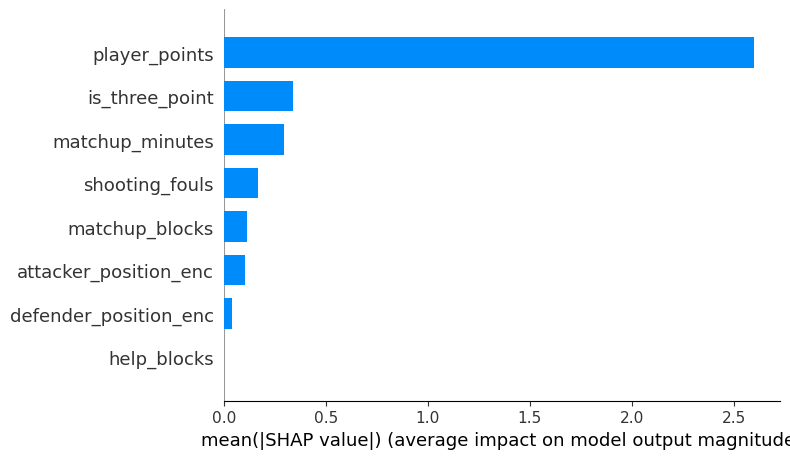

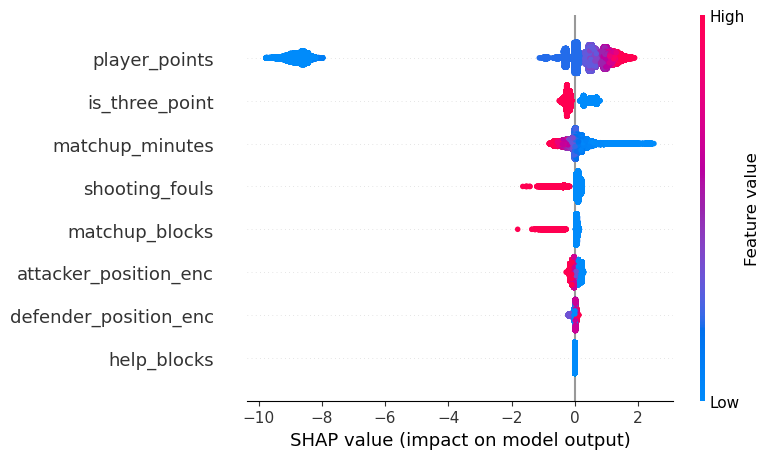

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import shap

# Make a working copy of the dataset
df = shot_df.copy()

# Fill NaNs with 0 (instead of dropping)
df.fillna(0, inplace=True)

# Encode positions (make sure to convert to string to avoid issues with float NaNs)
le_attacker_pos = LabelEncoder()
le_defender_pos = LabelEncoder()

df['attacker_position_enc'] = le_attacker_pos.fit_transform(df['attacker_position'].astype(str))
df['defender_position_enc'] = le_defender_pos.fit_transform(df['defender_position'].astype(str))

# Define features and label
feature_cols = [
    'is_three_point', 'matchup_minutes', 'matchup_blocks',
    'help_blocks', 'shooting_fouls', 'player_points',
    'attacker_position_enc', 'defender_position_enc'
]

X = df[feature_cols]
y = df['is_made']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Full breakdown
shap.summary_plot(shap_values, X_test)

In [99]:
# -----------------------------
# Predict Shot Make Probabilities
# -----------------------------
df['predicted_make_prob'] = model.predict_proba(X)[:, 1]

# -----------------------------
# Aggregate into Defender Ratings
# -----------------------------
# Only include defenders with enough data (e.g., 100+ shots)
qualified_defenders = (
    df.groupby('defender_id')
      .agg(total_shots=('predicted_make_prob', 'count'))
      .query('total_shots >= 100')
      .index
)

# Compute average predicted shot make probability for each defender
defender_scores = (
    df[df['defender_id'].isin(qualified_defenders)]
    .groupby('defender_id')['predicted_make_prob']
    .mean()
    .reset_index()
    .rename(columns={'predicted_make_prob': 'defensive_rating'})
    .sort_values('defensive_rating')
)

# Merge with defender position or name (if available)
defender_metadata = df[['defender_id', 'defender_position']].drop_duplicates()
defender_scores = defender_scores.merge(defender_metadata, on='defender_id', how='left')

# -----------------------------
# (Optional) Normalize for 0-100 rating
# -----------------------------
defender_scores['dpoy_score'] = (
    (1 - defender_scores['defensive_rating']) * 100
).round(2)

# Sort best defenders at the top
defender_scores = defender_scores.sort_values(by='dpoy_score', ascending=False)

# Preview top 10
print(defender_scores.head(10))

   defender_id  defensive_rating defender_position  dpoy_score
0      1630699          0.315657                 0   68.430000
2       201959          0.334903                 0   66.510002
1       201959          0.334903                 C   66.510002
3      1631103          0.350424                 0   64.959999
5      1629618          0.369184                 G   63.080002
4      1629618          0.369184                 0   63.080002
6      1629057          0.379247                 0   62.080002
7      1629057          0.379247                 C   62.080002
8      1628470          0.384411                 0   61.560001
9      1628470          0.384411                 F   61.560001


In [100]:
# Load the original matchups dataset
matchups_df = pd.read_csv("matchups_2024.csv")

# Create full name from first and last name
matchups_df['defender_name'] = matchups_df['matchups_first_name'].astype(str) + " " + matchups_df['matchups_family_name'].astype(str)

# Build the mapping: matchups_person_id → defender_name
defender_name_map = (
    matchups_df[['matchups_person_id', 'defender_name']]
    .drop_duplicates()
    .rename(columns={'matchups_person_id': 'defender_id'})
    .set_index('defender_id')['defender_name']
    .to_dict()
)

# Add defender names to your scores table
defender_scores['defender_name'] = defender_scores['defender_id'].map(defender_name_map)

# Sort or filter as needed
defender_scores = defender_scores[['defender_name', 'defensive_rating', 'dpoy_score', 'defender_position']]
defender_scores = defender_scores.sort_values(by='dpoy_score', ascending=False)

defender_scores.head(10)

,defender_name,defensive_rating,dpoy_score,defender_position
0,MarJon Beauchamp,0.315657,68.430000,0
1,Taj Gibson,0.334903,66.510002,C
2,Taj Gibson,0.334903,66.510002,0
3,Malaki Branham,0.350424,64.959999,0
4,Jalen Pickett,0.369184,63.080002,0
5,Jalen Pickett,0.369184,63.080002,G
6,Robert Williams III,0.379247,62.080002,0
7,Robert Williams III,0.379247,62.080002,C
8,Torrey Craig,0.384411,61.560001,0
9,Torrey Craig,0.384411,61.560001,F


In [101]:
defender_scores.tail(10)

,defender_name,defensive_rating,dpoy_score,defender_position
934,Pete Nance,0.550516,44.950001,0
935,Pete Nance,0.550516,44.950001,C
936,Jonas Valančiūnas,0.553249,44.680000,0
937,Jonas Valančiūnas,0.553249,44.680000,C
938,Alex Reese,0.560076,43.990002,0
939,Kylor Kelley,0.567135,43.290001,0
940,Kylor Kelley,0.567135,43.290001,C
941,Jared Rhoden,0.570198,42.980000,0
942,Jared Rhoden,0.570198,42.980000,G
943,Jared Rhoden,0.570198,42.980000,F


In [102]:
defender_scores['defender_name' == 'Jaylen Brown']

KeyError: False